<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 0px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../../utils/risklab_ai.gif" width="60px" style="border: 0; margin-bottom:-10px; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; margin-left:0; font-weight: bold; text-align: left; font-size: 38px;">
      Introduction to Structural Breaks in Finance
    </h1>
  </div>  
</div>

This notebook demonstrates how to detect structural breaks and financial bubbles using the RiskLabAI library.

We will perform the following steps:
1.  Load and prepare U.S. housing data (Case-Shiller Index) from the FRED database.
2.  Plot the log-price to visually identify the 2000s housing bubble.
3.  Use `get_expanding_window_adf` to generate a time series of the ADF statistic.
4.  Plot the ADF statistic against the log-price to see when the series entered an explosive regime.
5.  Use `get_bsadf_statistic` to compute a single, formal test statistic for the bubble's origination.

## 0. Setup and Imports

First, we import our libraries and the necessary modules from `RiskLabAI`.

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fredapi
from dotenv import load_dotenv

# RiskLabAI Imports
import RiskLabAI.features.structural_breaks as sb
import RiskLabAI.utils.publication_plots as pub_plots

# --- FRED API Configuration ---
# This finds the .env file and loads FRED_API_KEY into os.environ
load_dotenv()

# To run the code on your computer, register for a free FRED API and uncomment the following line
# FRED_API_KEY = 'YOUR_FRED_API_KEY'

# --- Global Plotting Settings ---
SAVE_PLOTS = False
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent'
PLOT_QUALITY = 300
SAVE_DIR = 'figs'

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving disabled.


## 1. Load and Prepare Data

We'll use the Case-Shiller U.S. National Home Price Index (`CSUSHPINSA`) from 1990 to 2015. This dataset provides a clear example of the 2000s housing bubble. We will use the log of the price, as required by the ADF test.

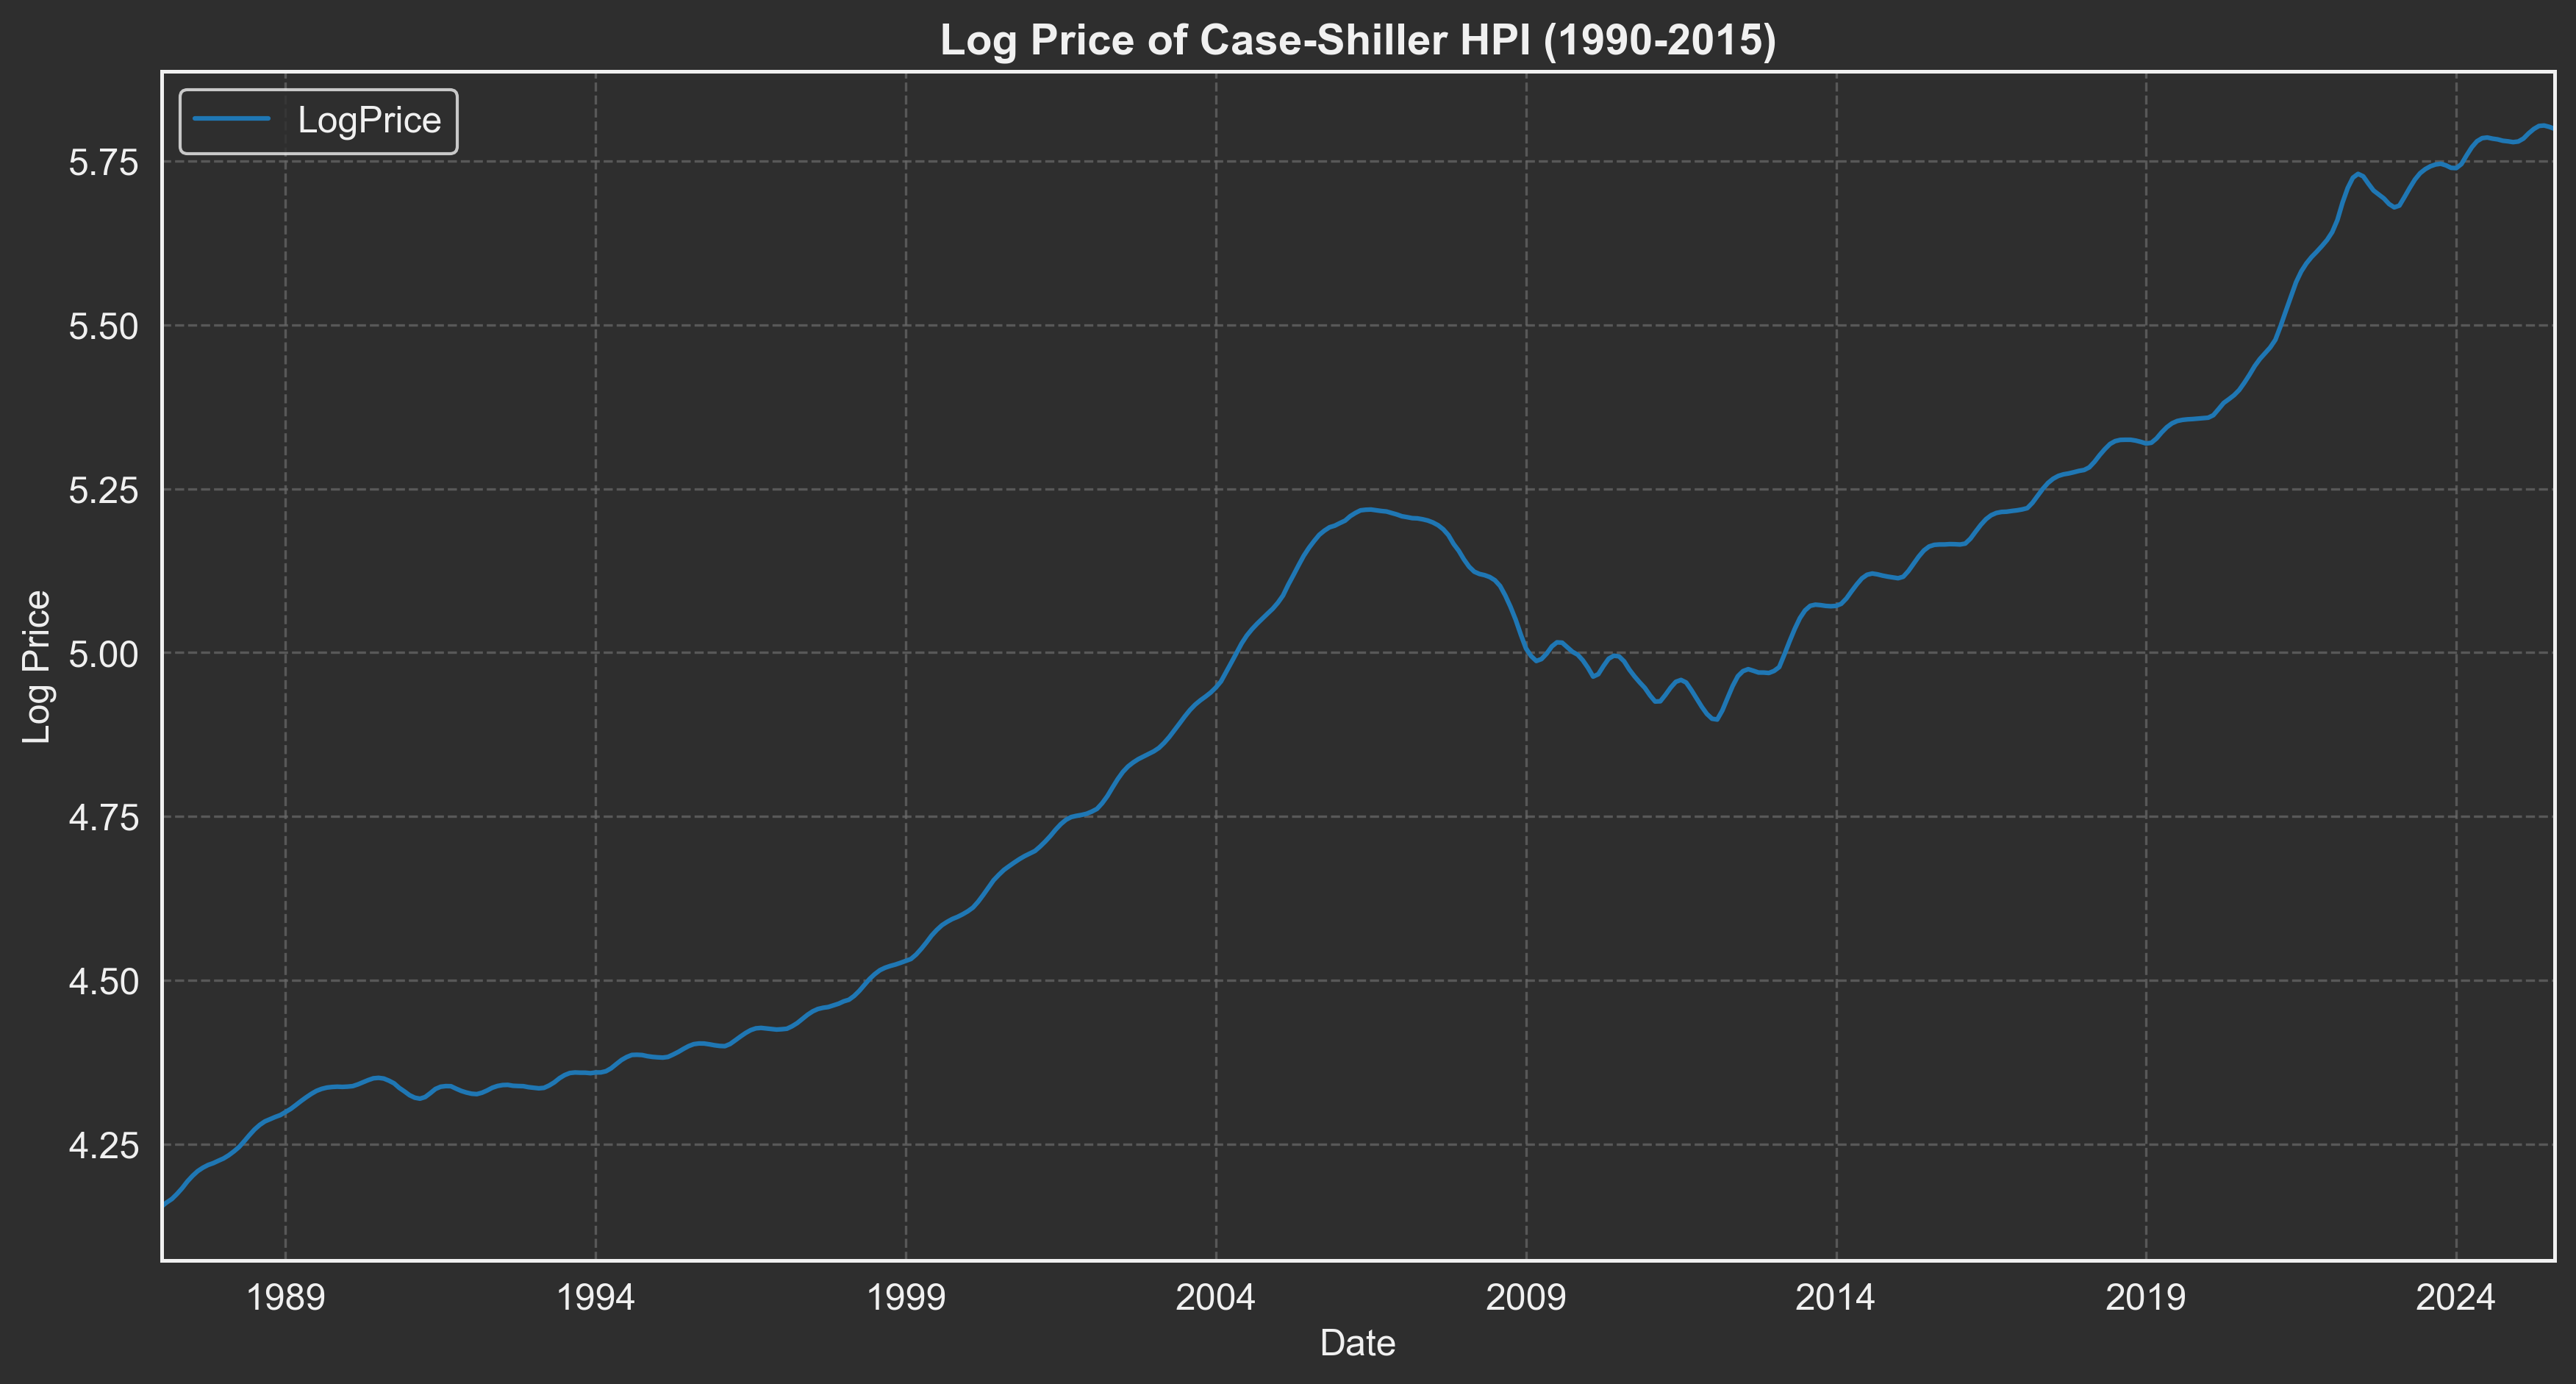

In [2]:
try:
    # Check if FRED_API_KEY is defined
    if 'FRED_API_KEY' not in locals() and 'FRED_API_KEY' not in os.environ:
        raise NameError("FRED_API_KEY not set. Please get a key from FRED and uncomment the line in the setup cell.")
        
    # Use environment variable if local one isn't set
    api_key = locals().get('FRED_API_KEY', os.environ.get('FRED_API_KEY'))
    
    # 1. Initialize FRED API
    fred = fredapi.Fred(api_key=api_key)

    # 2. Load Case-Shiller data
    data = fred.get_series('CSUSHPINSA', start_time='1990-01-01', end_time='2015-01-01')

    # 3. Convert to log price and drop any missing values
    log_price = np.log(data).to_frame("LogPrice").dropna()

    # --- 4. Plotting ---
    fig, ax = plt.subplots(figsize=(14, 7))
    log_price.plot(ax=ax, label='Log Price (Case-Shiller HPI)')

    pub_plots.apply_plot_style(
        ax, 
        'Log Price of Case-Shiller HPI (1990-2015)', 
        'Date', 
        'Log Price'
    )
    ax.legend()
    pub_plots.finalize_plot(fig, "log_price_plot.png")

except NameError as e:
    print(f"Error: {e}")
    print("Skipping remaining cells. Please set your FRED API key.")
except Exception as e:
    print(f"An error occurred while fetching data: {e}")
    print("Skipping remaining cells.")

## 2. Expanding Window ADF Test

Now, we'll run the `get_expanding_window_adf` test. This function calculates the ADF t-statistic for an expanding window of data, starting with a `min_sample_length`. We'll use 60 months (5 years) as our minimum, since this is monthly data.

A standard ADF test looks for stationarity (a *negative* t-stat). However, when testing for bubbles, we look for **explosive behavior**, which is indicated by a *positive and rising* t-statistic that crosses a critical value.

In [3]:
# We run this inside a 'try' block to ensure 'log_price' was loaded
try:
    if 'log_price' not in locals():
        raise NameError("Data was not loaded. Skipping ADF calculation.")
        
    print("Running expanding window ADF...")
    adf_stats = sb.get_expanding_window_adf(
        log_price=log_price['LogPrice'], # Pass the Series
        min_sample_length=60, 
        constant='c',  # 'c' for constant/intercept
        lags=1         # Number of lags for delta prices
    )
    print("Calculation complete.")
    print(adf_stats.tail())

except NameError as e:
    print(e)

Running expanding window ADF...
Calculation complete.
2025-04-01   -0.135663
2025-05-01   -0.184703
2025-06-01   -0.301912
2025-07-01   -0.394920
2025-08-01   -0.439285
dtype: float64


## 3. Plotting the ADF Statistic

Let's plot the log-price against the ADF statistic. We'll add a hypothetical critical value line. When the ADF statistic (blue) rises *above* this line, it signals an explosive, bubble-like regime.

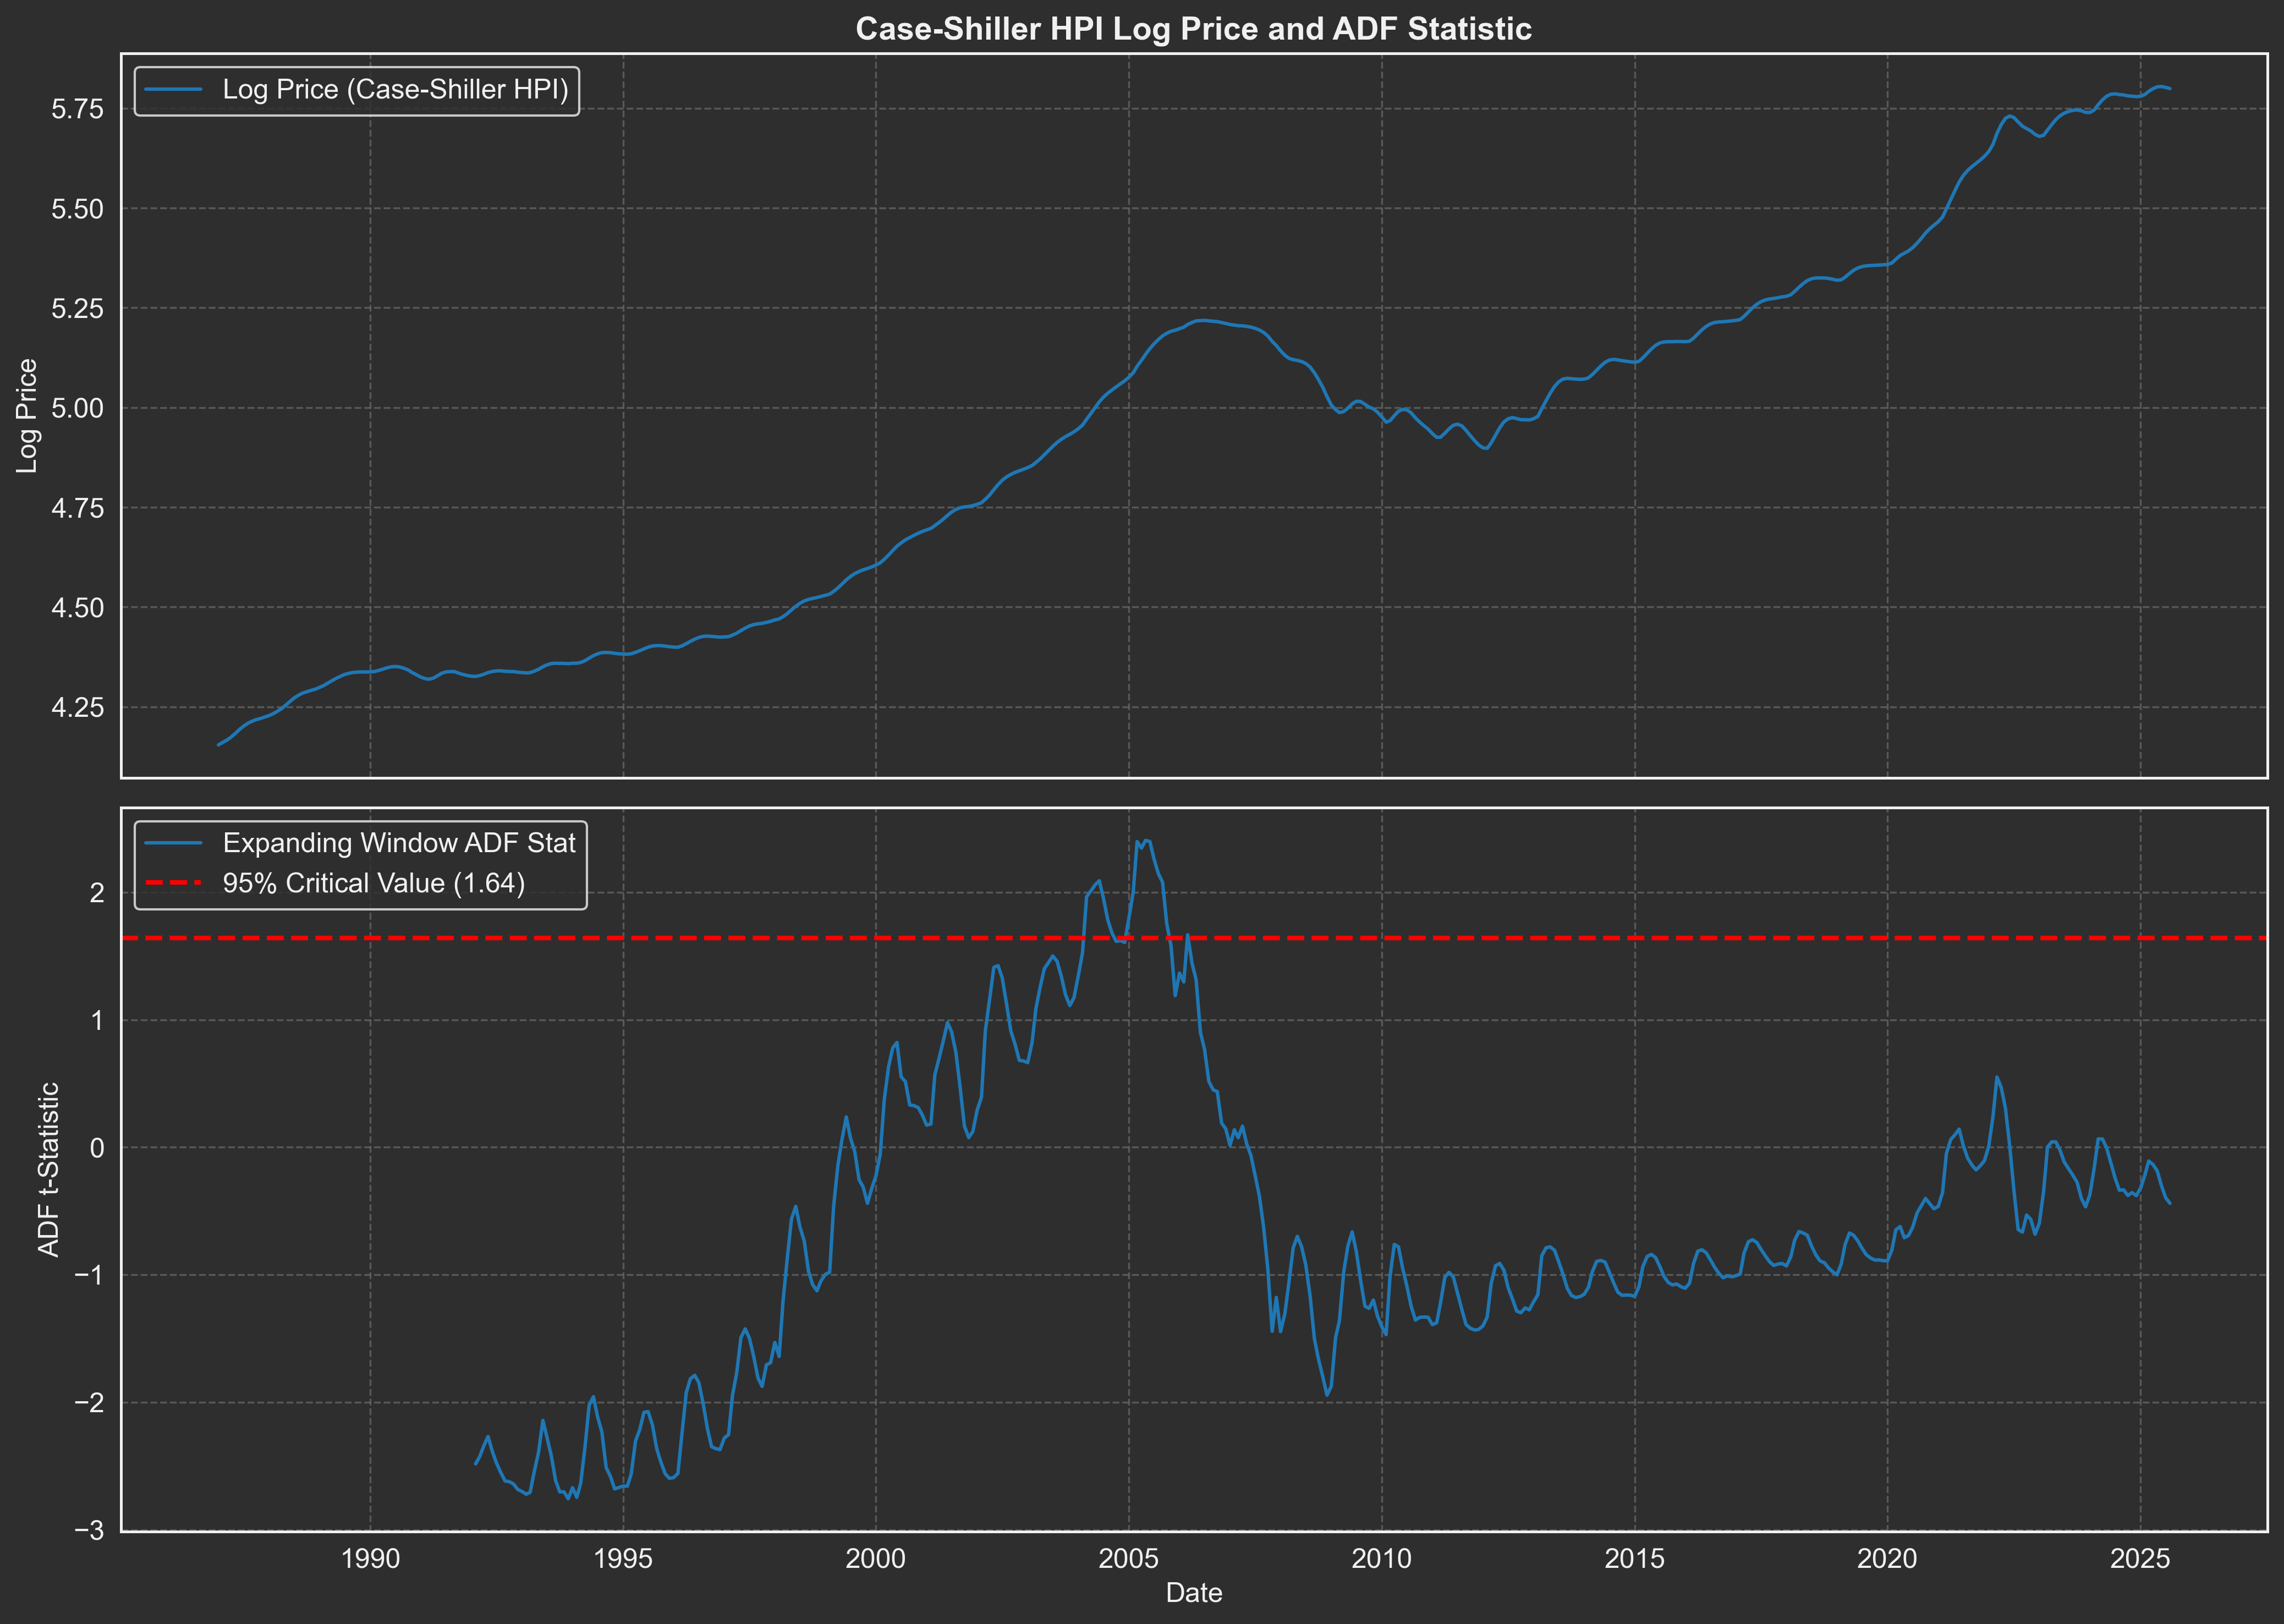

In [4]:
# We run this inside a 'try' block to ensure 'adf_stats' was calculated
try:
    if 'adf_stats' not in locals():
        raise NameError("ADF statistics were not calculated. Skipping plot.")

    # Critical value (example, real values must be computed via Monte Carlo)
    # 95% critical value for this test is often around 1.6 - 2.0
    critical_value = 1.64 

    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Panel 1: Log Price
    ax1.plot(log_price.index, log_price['LogPrice'], label='Log Price (Case-Shiller HPI)')
    pub_plots.apply_plot_style(ax1, 'Case-Shiller HPI Log Price and ADF Statistic', '', 'Log Price')
    ax1.legend(loc='upper left')

    # Panel 2: ADF Statistic
    ax2.plot(adf_stats.index, adf_stats, label='Expanding Window ADF Stat')
    ax2.axhline(y=critical_value, color='red', linestyle='--', linewidth=2, label=f'95% Critical Value ({critical_value})')
    pub_plots.apply_plot_style(ax2, '', 'Date', 'ADF t-Statistic')
    ax2.legend(loc='upper left')

    plt.tight_layout()
    pub_plots.finalize_plot(fig, "adf_statistic_plot.png")

except NameError as e:
    print(e)

**Analysis:** The plot clearly shows the power of this method. 

* During the stable periods of the 1990s, the ADF statistic stays low.
* As the housing bubble begins to inflate (around 2004-2007), the statistic rises dramatically, crossing the critical value.
* After the bubble bursts, the statistic falls again as the price action is no longer explosive.

This confirms the `get_expanding_window_adf` function is correctly identifying periods of explosive behavior.

## 4. Backward Supremum ADF (BSADF) Test

While the expanding window plot is great for visualization, a formal test requires a single statistic. The BSADF test (implemented as `get_bsadf_statistic`) finds the *supremum* (the highest peak) of the ADF statistics calculated over *all possible start dates*.

This single value can be compared against a critical value table to formally reject the null hypothesis of no bubble.

In [5]:
# We run this inside a 'try' block to ensure 'log_price' was loaded
try:
    if 'log_price' not in locals():
        raise NameError("Data was not loaded. Skipping BSADF calculation.")
        
    print("Running BSADF test...")
    bsadf_result = sb.get_bsadf_statistic(
        log_price=log_price['LogPrice'], # Pass the Series
        min_sample_length=60,
        constant='c',
        lags=1
    )

    # DEBUG: Use the 'bsadf' key we fixed in the .py file
    print(f"BSADF Statistic: {bsadf_result['bsadf']:.4f}")
    print(f"(Test run as of: {bsadf_result['Time'].date()})")

except NameError as e:
    print(e)

Running BSADF test...
BSADF Statistic: -0.1128
(Test run as of: 2025-08-01)
